In [1]:
from __future__ import print_function, division

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from mpl_toolkits.axes_grid1 import ImageGrid
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
torch.manual_seed(0)

In [3]:
data_dir = '/scratch/mk7711/dast/style+og//'
train = 'train'
val = 'validation'
test = 'test'

data_transforms = {
    train: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(254),
        #transforms.RandomRotation(10),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    val: transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [train, val, test]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True, num_workers=4
    )
    for x in [train, val, test]
}
print(len(dataloaders['train']))

dataset_sizes = {x: len(image_datasets[x]) for x in [train, val, test]}

for x in [train, val, test]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[train].classes
print(image_datasets[train].classes)

181
Loaded 5782 images under train
Loaded 1442 images under validation
Loaded 498 images under test
Classes: 
['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


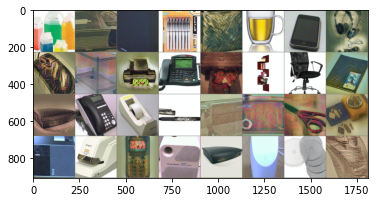

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [5]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print("Learning Rate: ", exp_lr_scheduler.get_lr())
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                  epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
        
        scheduler.step()        
        
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#For pre-trained model
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

In [ ]:
model = models.resnet50(pretrained=False)

In [ ]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 31)

In [6]:
if use_gpu:
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00001, betas=(0.9,.999), weight_decay=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

dloaders = {'train':dataloaders['train'], 'valid':dataloaders['validation']}

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=31, bias=True)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [7]:
start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=100)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

/home/mk7711/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Learning Rate:  [1e-05]
Epoch [0/99] train loss: 0.1069 acc: 0.0479 valid loss: 0.1075 acc: 0.0784


/home/mk7711/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Learning Rate:  [1e-05]
Epoch [1/99] train loss: 0.1036 acc: 0.1102 valid loss: 0.1040 acc: 0.1436
Learning Rate:  [1e-05]
Epoch [2/99] train loss: 0.1006 acc: 0.1911 valid loss: 0.1011 acc: 0.2323
Learning Rate:  [1e-05]
Epoch [3/99] train loss: 0.0978 acc: 0.2826 valid loss: 0.0981 acc: 0.3121
Learning Rate:  [1e-05]
Epoch [4/99] train loss: 0.0952 acc: 0.3461 valid loss: 0.0955 acc: 0.3655
Learning Rate:  [1e-05]
Epoch [5/99] train loss: 0.0925 acc: 0.4042 valid loss: 0.0922 acc: 0.4286
Learning Rate:  [1e-05]
Epoch [6/99] train loss: 0.0899 acc: 0.4504 valid loss: 0.0899 acc: 0.4612
Learning Rate:  [1e-05]
Epoch [7/99] train loss: 0.0875 acc: 0.4950 valid loss: 0.0870 acc: 0.4917
Learning Rate:  [1e-05]
Epoch [8/99] train loss: 0.0852 acc: 0.5161 valid loss: 0.0850 acc: 0.5229
Learning Rate:  [1.0000000000000002e-07]
Epoch [9/99] train loss: 0.0839 acc: 0.5372 valid loss: 0.0850 acc: 0.5243
Learning Rate:  [1.0000000000000002e-06]
Epoch [10/99] train loss: 0.0837 acc: 0.5346 valid 

Learning Rate:  [1.0000000000000006e-12]
Epoch [73/99] train loss: 0.0814 acc: 0.5586 valid loss: 0.0821 acc: 0.5485
Learning Rate:  [1.0000000000000006e-12]
Epoch [74/99] train loss: 0.0815 acc: 0.5574 valid loss: 0.0823 acc: 0.5458
Learning Rate:  [1.0000000000000006e-12]
Epoch [75/99] train loss: 0.0815 acc: 0.5600 valid loss: 0.0821 acc: 0.5430
Learning Rate:  [1.0000000000000006e-12]
Epoch [76/99] train loss: 0.0814 acc: 0.5636 valid loss: 0.0826 acc: 0.5388
Learning Rate:  [1.0000000000000006e-12]
Epoch [77/99] train loss: 0.0815 acc: 0.5566 valid loss: 0.0819 acc: 0.5465
Learning Rate:  [1.0000000000000006e-12]
Epoch [78/99] train loss: 0.0814 acc: 0.5557 valid loss: 0.0822 acc: 0.5388
Learning Rate:  [1.0000000000000008e-14]
Epoch [79/99] train loss: 0.0815 acc: 0.5590 valid loss: 0.0821 acc: 0.5444
Learning Rate:  [1.0000000000000007e-13]
Epoch [80/99] train loss: 0.0814 acc: 0.5559 valid loss: 0.0816 acc: 0.5430
Learning Rate:  [1.0000000000000007e-13]
Epoch [81/99] train los

In [8]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[test])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[test]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        inputs, labels = data

        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(),labels.cuda()
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        #gc.collect()
        
    avg_loss = loss_test / dataset_sizes[test]
    avg_acc = acc_test / dataset_sizes[test]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [9]:
eval_model(model, criterion)

Evaluating model
----------
Test batch 0/16
Evaluation completed in 0m 8s
Avg loss (test): 0.0778
Avg acc (test): 0.6486
----------
